In [1]:
%pylab inline
import GPyOptmsa
import GPyOpt
import GPy
from numpy.random import seed
import numpy as np
from GPyOptmsa.util.general import samples_multidimensional_uniform, multigrid

import warnings
warnings.filterwarnings("ignore")
seed(12345)

Populating the interactive namespace from numpy and matplotlib


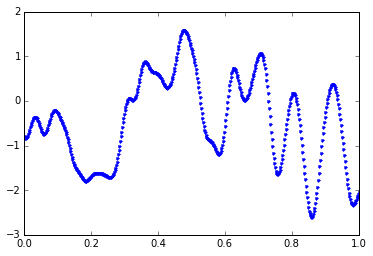

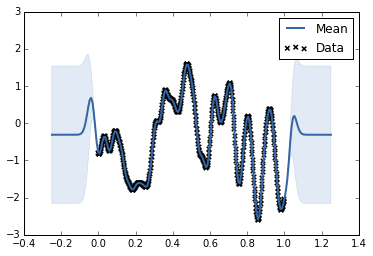

In [8]:
# Generate the function to optimize
k = GPy.kern.RBF(input_dim=1,lengthscale=0.025) + GPy.kern.Bias(input_dim=1)

x = np.linspace(0.,1.,500) # define X to be 500 points evenly spaced over [0,1]
x = x[:,None] # reshape X to make it n*p --- we try to use 'design matrices' in GPy 

mu = np.zeros((500)) # vector of the means --- we could use a mean function here, but here it is just zero.
C = k.K(x,x) # compute the covariance matrix associated with inputs X

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
seed(5)
z = np.random.multivariate_normal(mu,C,1).T
plt.plot(x,z,'.')

# point interpolation
m = GPy.models.GPRegression(x,z,kernel=k)
m.optimize()
m.plot()


In [9]:
# objective fucntion

class objective_gp():
    def __init__(self,model):
        self.model = model
    
    def f(self,x):
        return self.model.predict(x)[0]

obj = objective_gp(m)  
f = obj.f
bounds = [(0,1)]

In [ ]:
# --- Matrices to save results

NR = 5
n_init          = 5             # number of initial points (per dimension).
max_iter_dim    = 10            # Number of iterations (per dimension).
input_dim = len(bounds)

res_GLASSES_H    = np.empty([1,2])
res_EL            = np.empty([1,2])


# --- replicates 
for k in range(NR):
    
    print k
    seed(k)
    # --- inital points
    X = samples_multidimensional_uniform(bounds,n_init*len(bounds))
    Y = f(X)

    # --- Crete the optimization objects
    GLASSES_H    = GPyOptmsa.msa.GLASSES(f,bounds, X,Y,exact_feval=True)
    EL           = GPyOpt.methods.BayesianOptimization(f=f,bounds=bounds, X=X, Y=Y ,acquisition='EL',exact_feval=True) 


    print 'GLASSES_H'
    GLASSES_H.run_optimization(max_iter=max_iter_dim*input_dim,ahead_remaining = True)  
    rep_col     = [k]*GLASSES_H.Y_best.shape[0]
    res_GLASSES_H    = np.vstack((res_GLASSES_H,np.vstack((rep_col,GLASSES_H.Y_best)).T))
    np.savetxt('res_GLASSES_H_'+ '1D' +'.txt', res_GLASSES_H)

    print 'EL'
    EL.run_optimization(max_iter=max_iter_dim*input_dim, acqu_optimize_method='DIRECT')  
    rep_col     = [k]*EL.Y_best.shape[0]
    res_EL    = np.vstack((res_EL,np.vstack((rep_col,EL.Y_best)).T))
    np.savetxt('res_EL_'+ '1D' +'.txt', res_EL)

0
Optimization restart 1/5, f = 2.18315211635
Optimization restart 2/5, f = 2.18315142354
Optimization restart 3/5, f = 2.18315136446
Optimization restart 4/5, f = 2.18315580665
Optimization restart 5/5, f = 2.18315483326
GLASSES_H

In [37]:
# -------- make comparison plot 
# choose experiment

n_exp = len(experiments)
methods = ['EL','GL-H']

results_mean = np.zeros((n_exp,len(methods)))
results_min = np.zeros((n_exp,len(methods)))
results_median = np.zeros((n_exp,len(methods)))

for k in range(len(experiments)): 
    results_mean[k,:] = create_table(experiments[k]).mean(1)
    results_min[k,:] = create_table(experiments[k]).min(1)
    results_median[k,:] = np.median(create_table(experiments[k]),1)


def create_table(experiment):    
    results = np.zeros((1,10))
    results[0,:] = value_at_last(np.loadtxt('res_EL_'+experiment[7:]+'.txt')[1:,:])
    results[1,:] = value_at_last(np.loadtxt('res_GLASSES_H_'+experiment[7:]+'.txt')[1:,:])
    return results

def value_at_last(data):
    data_val = data[:,1]
    data_id  = data[:,0]
    from itertools import groupby
    return np.array([data_val[data_id==i].min() for i, _ in groupby(data_id)])


NameError: name 'experiments' is not defined